In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, InputLayer, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape, Dropout, Activation, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model as plot
from tensorflow.keras import Model
import pandas as pd
import skimage
print(tf.__version__)

2.3.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

#DataLoader

In [151]:
#dataloader
from glob import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE

class DataLoader:

#Constructor
  def __init__(self, images, img_size, batch_size=8, buffer_size=1024):
    self.images = images
    self.img_size = img_size
    self.batch_size = batch_size
    self.buffer_size = buffer_size

#Size of dataset
  def __len__(self):
    return len(self.images)

#Function to read and decode images
  @staticmethod
  def read_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None,3])
    image = tf.cast(image, dtype=tf.float32)
    return image

#Resizing and Normalizing images
  @staticmethod
  def resNormImg(image, img_size):
    res_img = tf.image.resize(image, [img_size, img_size], 'bicubic')
    res_img = res_img/255.0
    return res_img

#Adding noise to image
  @staticmethod
  def addNoise(input_img):
    mean = 0
    stdv = 70
    #noise_factor = 0.4
    #noise = noise_factor * np.random.normal(loc=0.0, scale=0.12, size=input_img.shape)
    noise = np.random.randint(mean, stdv, input_img.shape)
    noisy_img = input_img + noise/255.0
    noisy_img = tf.clip_by_value(noisy_img, 0.0, 1.0)
    return noisy_img

#generating input and truth images
  @tf.function
  def map_function(self, image_file):
    image = self.read_image(image_file)
    truth = self.read_image(image_file)
    img = self.resNormImg(image, self.img_size)
    truth = self.resNormImg(truth, self.img_size)
    img = self.addNoise(img)
    return img, truth

#creating dataset
  def make_dataset(self):
    dataset = tf.data.Dataset.from_tensor_slices(self.images)
    dataset = dataset.shuffle(self.buffer_size, seed=2)
    dataset = dataset.map(
        self.map_function,
        num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.batch(self.batch_size, drop_remainder=True)
    #dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

Downloading PASCAL VOC 2007 Dataset

In [4]:
!wget https://data.deepai.org/PASCALVOC2007.zip

--2020-11-24 10:12:01--  https://data.deepai.org/PASCALVOC2007.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1774851628 (1.7G) [application/x-zip-compressed]
Saving to: ‘PASCALVOC2007.zip’

PASCALVOC2007.zip   100%[===================>]   1.65G  20.6MB/s    in 84s     

2020-11-24 10:13:26 (20.2 MB/s) - ‘PASCALVOC2007.zip’ saved [1774851628/1774851628]



In [5]:
import zipfile
local_zip = '/content/PASCALVOC2007.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/VOCTrainVal/')
zip_ref.close()

In [6]:
img_size = 256
n_ch = 3
batch_size = 8
buf_size = 1024

In [152]:
stl_file_path = '/content/STL10/train_images/' 
voc_file_path = '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
dat = glob(voc_file_path + '*')
dataloader = DataLoader(dat, img_size, batch_size, buf_size)
print(dataloader.__len__())
print(dataloader.images)  

5011
['/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005947.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000450.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005960.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/006306.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002291.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002666.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002277.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001618.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007422.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007511.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002238.jpg', '/content/VOCTrainVal/VOCt

Testing Noise Function

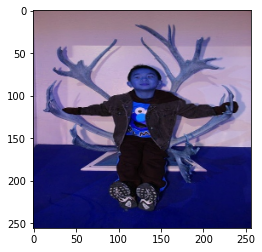

255.0
(256, 256, 3)
{0: 2, 1: 3, 2: 12, 3: 8, 4: 15, 5: 17, 6: 39, 7: 56, 8: 89, 9: 117, 10: 156, 11: 204, 12: 252, 13: 304, 14: 349, 15: 429, 16: 474, 17: 454, 18: 510, 19: 509, 20: 511, 21: 546, 22: 531, 23: 563, 24: 600, 25: 603, 26: 582, 27: 585, 28: 586, 29: 645, 30: 619, 31: 648, 32: 665, 33: 680, 34: 687, 35: 665, 36: 668, 37: 685, 38: 727, 39: 730, 40: 713, 41: 763, 42: 760, 43: 732, 44: 748, 45: 760, 46: 767, 47: 828, 48: 796, 49: 800, 50: 790, 51: 776, 52: 795, 53: 809, 54: 860, 55: 845, 56: 851, 57: 819, 58: 861, 59: 873, 60: 826, 61: 808, 62: 849, 63: 888, 64: 814, 65: 814, 66: 862, 67: 861, 68: 857, 69: 938, 70: 858, 71: 867, 72: 898, 73: 921, 74: 875, 75: 932, 76: 860, 77: 883, 78: 890, 79: 792, 80: 748, 81: 757, 82: 706, 83: 676, 84: 577, 85: 572, 86: 520, 87: 521, 88: 536, 89: 512, 90: 462, 91: 463, 92: 491, 93: 458, 94: 465, 95: 471, 96: 523, 97: 467, 98: 488, 99: 474, 100: 493, 101: 525, 102: 508, 103: 505, 104: 531, 105: 489, 106: 505, 107: 494, 108: 502, 109: 493, 1

True

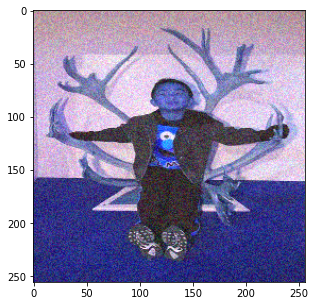

In [138]:
test_img = cv.imread(random.choice(dataloader.images), 1)#cv.imread('/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007586.jpg', 1)
test_img = cv.resize(test_img, (img_size,img_size))
test_img = test_img.astype(np.float32)
test_img = test_img/255.0
plt.imshow(test_img)
plt.show()
#test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
#ns = test_img
ns = DataLoader.addNoise(test_img)
ns = ns.numpy()*255

#ns = ns/ns.max()
print(ns.max())
#print(ns[20:-20])
#ns = tf.cast(ns, dtype=tf.uint8)
#print(ns[20:-20])
#plt.imshow(cv.cvtColor(ns,cv.COLOR_RGB2BGR))
print(ns.shape)
ns = ns.astype(np.uint8)
plt.figure(figsize=(5,5))
plt.imshow(ns)
unique, counts = np.unique(ns[20:-20], return_counts=True)
print(dict(zip(unique,counts)))
unique, counts = np.unique(test_img, return_counts=True)
print(dict(zip(unique,counts)))
cv.imwrite('testdat7.jpg', ns)

In [153]:
dataset = dataloader.make_dataset()
dataset

<PrefetchDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [154]:
print(dataset.take(15))

<TakeDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>


Upsample and Downsample block definitions

In [11]:
def downsample(filters, size, stride):
  #dnblock = tf.keras.Sequential()
  conv = tf.keras.layers.Conv2D(filters, size, activation='relu',strides=stride, padding='same')
  #dnblock.add(conv)
  #return dnblock
  return conv
  
def upsample(filters, size, stride):
  #upblock = tf.keras.Sequential()
  deconv = tf.keras.layers.Conv2DTranspose(filters, size, activation='relu',strides=stride, padding='same')
  #upblock.add(deconv)
  #return upblock
  return deconv

Model Parameters

In [207]:
sgd = tf.keras.optimizers.SGD
adam = tf.keras.optimizers.Adam
rmsp = tf.keras.optimizers.RMSprop
pixel_mse = 'mean_squared_error'
lr = 0.0001

Building the DenoiseNet Models

In [13]:
def DenoiseNet(input_tensor):
  input = tf.keras.layers.Input(shape=input_tensor) #Model input

  down_stack = [                                            #Downsampling stack
               downsample(64, 4, 1), #(bs,256,256,64)
               downsample(64, 4, 2), #(bs,128,128,64)
               downsample(128, 4, 2), #(bs,64,64,128)
               downsample(256, 4, 2), #(bs,32,32,256)
               downsample(512, 4, 2) #(bs,16,16,512)
               ]

  up_stack = [                                               #Upsampling stack
             upsample(256, 4, 2), #(bs,32,32,256)
             upsample(128, 4, 2), #(bs,64,64,128)
             upsample(64, 4, 2), #(bs,128,128,64)
             upsample(64, 4, 2), #(bs,256,256,64)
             ]


  dsc = []
  x = input
  output = upsample(n_ch, 4, 1)

  for layer in down_stack:
    x = layer(x)
    dsc.append(x)

  dsc = reversed(dsc[:-1])

  for layer, skip_conn in zip(up_stack, dsc):
    x = layer(x)
    x = tf.keras.layers.Concatenate()([x, skip_conn])  #Creating Skip Connections

  x = output(x)  #Model Output

  return tf.keras.Model(inputs=input, outputs=x)

Baseline AutoEncoder

In [187]:
def EncDec(input_tensor):
  model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_tensor),
  downsample(64, 4, 2),# input_shape=input_tensor),
  downsample(64, 4, 2), 
  downsample(128, 4, 2), 
  downsample(256, 4, 2), 
  downsample(512, 4, 2),
  upsample(256, 4, 2),
  upsample(128, 4, 2),
  upsample(64, 4, 2),
  upsample(64, 4, 2),
  upsample(3, 4, 2)])
  return model

Structural Similarity Index Function

In [183]:
def ssim(y_true, y_pred, max_val=1.0):
  y_true = (y_true + max_val) / 2
  y_pred = (y_pred + max_val)/ 2
  ssim = tf.image.ssim(y_true, y_pred, max_val)
  return ssim

Peak Signal to Noise Ratio Function

In [184]:
def psnr(y_true, y_pred, max_val=1.0):
  y_true = (y_true + max_val) / 2
  y_pred = (y_pred + max_val) / 2
  psnr = tf.image.psnr(y_true, y_pred, max_val)
  return psnr

Compiling the Model

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 3136        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 65600       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 128)  131200      conv2d_16[0][0]                  
______________________________________________________________________________________

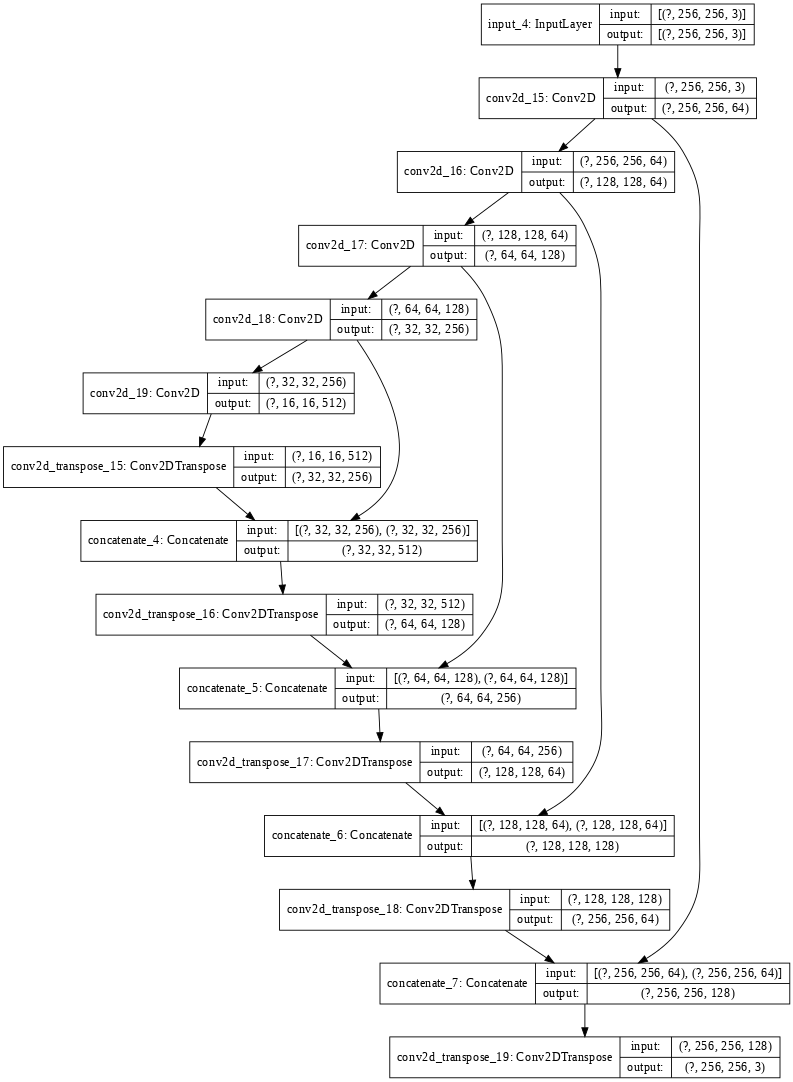

In [208]:
model = DenoiseNet((img_size,img_size, n_ch))#EncDec((img_size,img_size,n_ch))
model.compile(loss=pixel_mse, optimizer=adam(lr), metrics=['accuracy', ssim, psnr])
model.summary()
#model.save('EncDecNet.h5')
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [210]:
#model_used = 'AutoEncoder_VOC'
model_used = 'DenoiseNet_VOC'
print(model_used)

DenoiseNet_VOC


In [18]:
print(dataloader.__len__()//dataloader.batch_size)

626


In [ ]:
early_stopping = 

#Training the Model

In [203]:
model.fit(dataset,
          epochs=2,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

Epoch 1/2
626/626 [==============================] - 97s 155ms/step - loss: 3.2497e-04 - accuracy: 0.8546 - ssim: 0.9868 - psnr: 42.9246
Epoch 2/2
626/626 [==============================] - 97s 155ms/step - loss: 2.1006e-04 - accuracy: 0.8585 - ssim: 0.9895 - psnr: 43.6917


In [213]:
model.save(model_used+'.h5')

In [211]:
dependencies = {'ssim': ssim, 'psnr': psnr}
model = load_model(model_used+'.h5', compile=False,custom_objects= dependencies)
model.compile(loss=pixel_mse, optimizer=adam(lr), metrics=['accuracy', ssim, psnr])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 3136        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 65600       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  131200      conv2d_1[0][0]                   
_______________________________________________________________________________________

In [212]:
model.fit(dataset,
          epochs=10,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

Epoch 1/10
626/626 [==============================] - 90s 144ms/step - loss: 1.4770e-04 - accuracy: 0.8810 - ssim: 0.9912 - psnr: 45.3753
Epoch 2/10
626/626 [==============================] - 93s 149ms/step - loss: 1.4072e-04 - accuracy: 0.8824 - ssim: 0.9916 - psnr: 45.6005
Epoch 3/10
626/626 [==============================] - 94s 151ms/step - loss: 1.3770e-04 - accuracy: 0.8834 - ssim: 0.9917 - psnr: 45.7044
Epoch 4/10
626/626 [==============================] - 95s 152ms/step - loss: 1.3706e-04 - accuracy: 0.8832 - ssim: 0.9918 - psnr: 45.7163
Epoch 5/10
626/626 [==============================] - 95s 152ms/step - loss: 1.3451e-04 - accuracy: 0.8839 - ssim: 0.9919 - psnr: 45.8158
Epoch 6/10
626/626 [==============================] - 96s 154ms/step - loss: 1.3355e-04 - accuracy: 0.8841 - ssim: 0.9920 - psnr: 45.8425
Epoch 7/10
626/626 [==============================] - 96s 153ms/step - loss: 1.3131e-04 - accuracy: 0.8853 - ssim: 0.9920 - psnr: 45.9291
Epoch 8/10
626/626 [==============

#Visualizing the Model's Intermediate Layers

/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001050.jpg
(256, 256, 3)


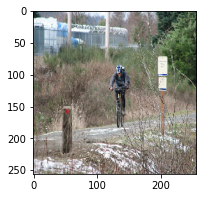

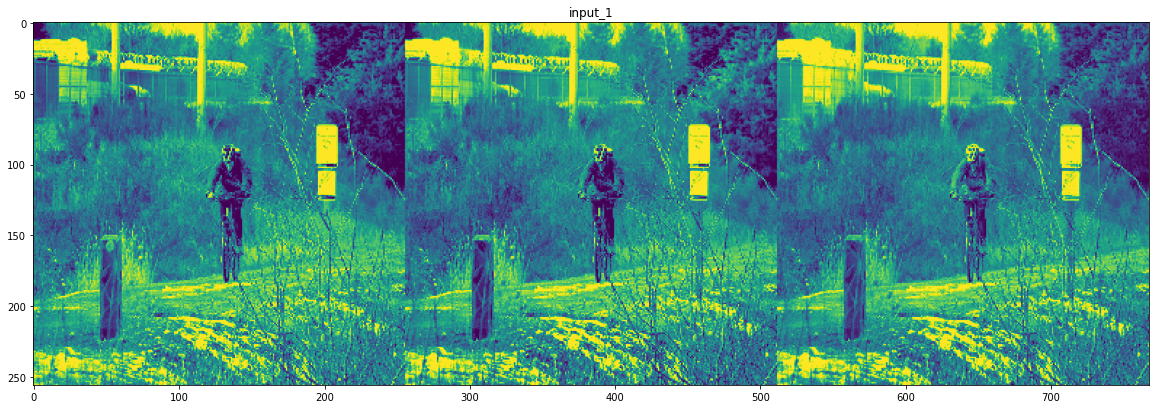

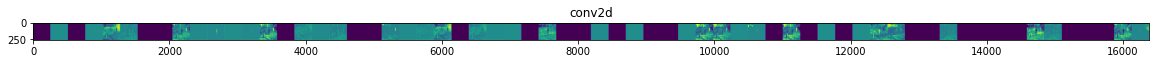

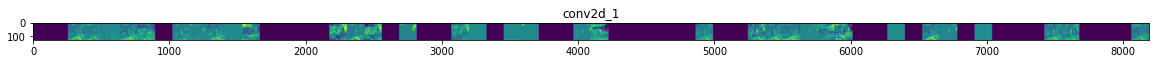

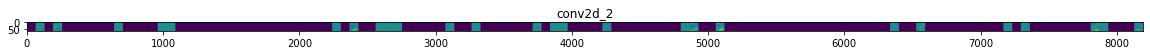

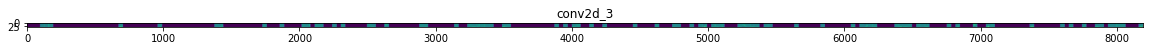

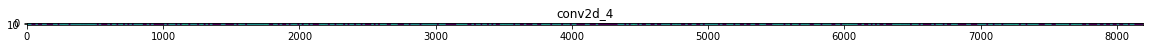

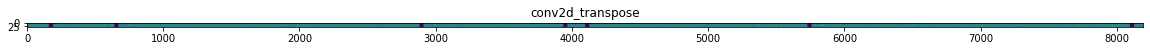

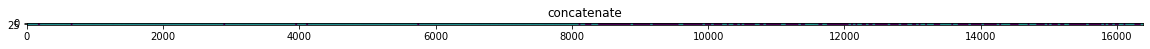

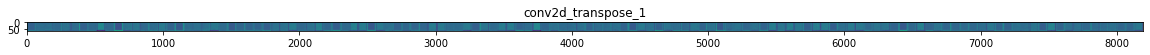

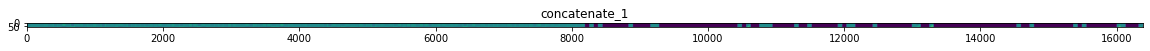

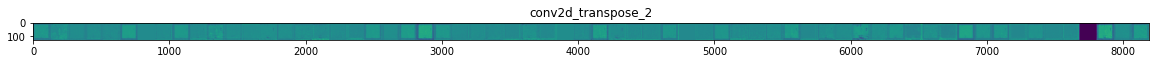

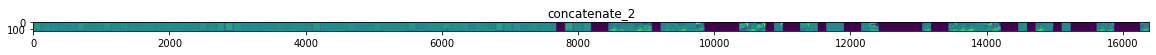

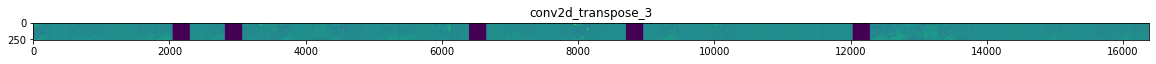

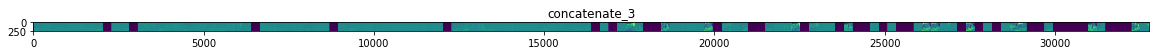

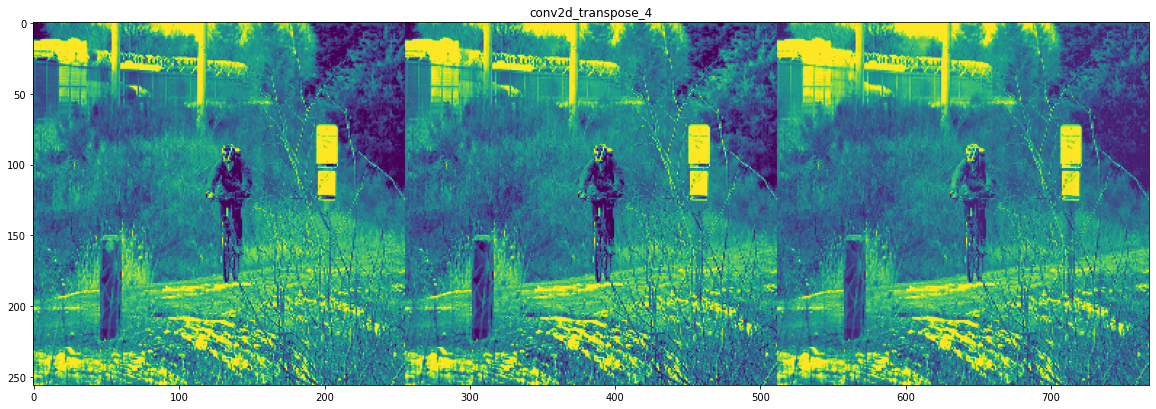

In [205]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
img_path = random.choice(dataloader.images)
#img = random.choice(dataloader.images)
#img = random.choice(x_train_noisy)
#img_path = '/content/testdat7.jpg'
print(img_path)
img = load_img(img_path, target_size=(img_size, img_size))
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()
x = x.reshape((1,) + x.shape)

x /= 255

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]

    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    if layer_name == 'input_5':
      img_b = display_grid[:,:img_size]
      img_g = display_grid[:,img_size:2*img_size]
      img_r = display_grid[:,2*img_size:]
      print(img_b.shape, img_g.shape, img_r.shape)
      rgb = img
      plt.imshow(rgb)
      plt.show()
      print(display_grid.shape)
    if layer_name == 'conv2d_transpose_29':
      img_b = display_grid[:,:img_size]
      img_g = display_grid[:,img_size:2*img_size]
      img_r = display_grid[:,2*img_size:]
      print(img_b.shape, img_g.shape, img_r.shape)
      rgb = img
      plt.imshow(rgb)
      plt.show()
      print(display_grid.shape)
      print(ssim(np.array(img), np.array(rgb)))

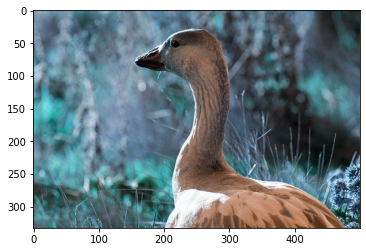

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


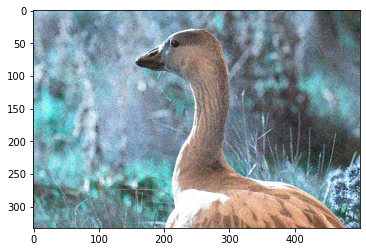

True

In [ ]:
test_img = cv.imread('/content/VOCTrainVal/VOCdevkit/VOC2007/JPEGImages/002310.jpg', 1)
plt.imshow(test_img)
plt.show()
ns = Noise.addNoise(test_img)
#ns = ns.numpy()
plt.imshow(ns)
plt.show()
#unique, counts = np.unique(ns[20:-20], return_counts=True)
#print(dict(zip(unique,counts)))
#unique, counts = np.unique(test_img, return_counts=True)
#print(dict(zip(unique,counts)))
cv.imwrite('testdat.jpg', ns)

#Displaying Predictions

In [ ]:
fs = 5

def show_predictions(image):
  pred = model.predict(image)
  plt.figure(figsize=(fs,fs))
  plt.title('Denoised Image')
  den_img = array_to_img(pred[0])
  den_img = np.array(den_img)
  den_img = cv.convertScaleAbs(den_img, alpha=1.2, beta=30)
  plt.imshow(den_img)
  plt.show()
  return den_img


test_img = cv.imread(random.choice(dataloader.images), 1)
test_img = cv.cvtColor(test_img, cv.COLOR_RGB2BGR)
test_img = cv.resize(test_img, (img_size,img_size))
test_img = test_img.astype(np.float32)
test_img = test_img/255.0
plt.figure(figsize=(fs,fs))
plt.title('Original Image')
plt.imshow(test_img)
plt.show()
ns = DataLoader.addNoise(test_img)
ns = ns.numpy()*255
print(ns.shape)
ns = ns.astype(np.uint8)


#img = load_img(path, target_size=(img_size, img_size))
#img_path = random.choice(dataloader.images)
#print(img_path)
#img = load_img(img_path, target_size=(img_size, img_size))
plt.figure(figsize=(fs,fs))
plt.title('Image with Noise')
plt.imshow(ns)
plt.show()
x = img_to_array(ns)
#x = Noise.addNoise(random.choice(x_train_noisy))
#plt.figure(figsize=(fs,fs))
#plt.title('Image with Noise')
#plt.imshow(x)
#plt.show()
x = np.expand_dims(x, axis=0)
#im_true = np.array(load_img('/content/STL10/test_images/test_image_png_104.png', target_size=(img_size,img_size)))
images = np.vstack([x])
print(images.shape)
den_img = show_predictions(images)
den_img= np.array(den_img)
#print(ssim(np.array(test_img), den_img))

In [105]:
voc_test_fp = '/content/VOCTrainVal/VOCtest_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
dat_test = glob(voc_file_path + '*')
test_dataloader = DataLoader(dat_test, img_size, batch_size, buf_size)
print(test_dataloader.__len__())
print(test_dataloader.images)

5011
['/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005947.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000450.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/005960.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/006306.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002291.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002666.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002277.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/001618.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007422.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/007511.jpg', '/content/VOCTrainVal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002238.jpg', '/content/VOCTrainVal/VOCt

In [221]:
test_dataset = test_dataloader.make_dataset()
test_dataset

<PrefetchDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [222]:
model.evaluate(test_dataset)

626/626 [==============================] - 38s 61ms/step - loss: 0.0145 - accuracy: 0.7966 - ssim: 0.9528 - psnr: 24.4796


[0.014525771141052246,
 0.7965685725212097,
 0.9527566432952881,
 24.47957420349121]